In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In this homework your task will be to modify `DecisionTreeClassifier` class from your practice in class.

In [4]:
data = pd.read_csv("telecom_churn.csv")
data = data.drop(['area code', 'phone number', 'state'], axis=1)
#data = data.drop(['state'], axis=1)

data.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Task 1 (0.5 points) <br/>

Download Telecom Data To Analyse The Churn Data Set `telecom_churn.csv`. Read it using `pandas.read_csv()` function. To open the function description use `Shift` + `Tab` . Show the first 5 rows of the dataset using `pandas.DataFrame.head()` function.

[Dataset Information](https://www.kaggle.com/spscientist/telecom-data/download):

Columns:
* state (State letter code)
* account length (How long the client has been served by the company)
* area code (Phone number prefix)
* phone number
* international plan (International roaming (connected / not connected))
* voice mail plan (Voice mail (connected / not connected))
* number vmail messages (Number of voice messages)
* total day minutes (Total duration of conversations during the day)
* total day calls (Total calls during the day)
* total day charge (Total amount of payment for services during the day)
* total eve minutes (Total duration of conversations in the evening)
* total eve calls (Total number of calls in the evening)
* total eve charge (Total amount of payment for services in the evening)
* total night minutes (Total duration of conversations at night)
* total night calls (Total number of calls at night)
* total night charge (Total amount of payment for services at night)
* total intl minutes (Total duration of international calls)
* total intl calls (Total number of international call)
* total intl charge (Total payment for international calls)
* customer service calls (The number of calls to the service center)
* churn

Churn is target: True - client has left.

* Which features are categorical? 
* Which features can be considered as object ID? Should we keep them? Why?

In [0]:
# Categorical feature: state, international plan, voice mail plan, churn
    
# Object ID: Phone number
# Потому что это единственное свойство, являющееся уникальным для каждого пассажира

### Task 2 (0.5 points) <br/>

The target column for classification is `Churn`. However, it is categorical feature, so you need to encode this by `0` and `1` values (False = 0, True = 1). Implement this mapping.

In [5]:
data.loc[:, 'churn'] = data.churn.replace({False: 0, True: 1})
data.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Create matrix `X` and vector of labels `y`. Split them into train and test samples using `sklearn.model_selection.train_test_split()` function from scikit-learn library. Also, set up random state in the function `random_state=42`.

Expected output dataframes names: `df_X_train`, `df_X_test` и `y_train`, `y_test`

In [0]:
X = data.drop(columns=['churn'])
y = data['churn']

df_X_train, df_X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Check your result
assert(round(df_X_test.size/X.size, 1)==0.2)
assert(round(y_test.size/y.size, 1)==0.2)

### Task 3 (2 points) categorical feature encoding

Use (0, 1) for binary features. Replace values both for `df_X_train` and `df_X_test`

In [8]:
df_X_train = df_X_train.replace({'international plan': {'no': 0, 'yes': 1},
                              
                                 'voice mail plan': {'no': 0, 'yes': 1}})
df_X_test = df_X_test.replace({'international plan': {'no': 0, 'yes': 1},
                                'voice mail plan': {'no': 0, 'yes': 1}})
df_X_train.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,243,0,0,0,95.5,92,16.24,163.7,63,13.91,264.2,118,11.89,6.6,6,1.78,2
1373,108,0,0,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4
679,75,1,0,0,222.4,78,37.81,327.0,111,27.80,208.0,104,9.36,8.7,9,2.35,1
56,141,0,0,0,126.9,98,21.57,180.0,62,15.30,140.8,128,6.34,8.0,2,2.16,1
1993,86,0,0,0,216.3,96,36.77,266.3,77,22.64,214.0,110,9.63,4.5,3,1.22,0


Now, let's implement target encoding for other categorical features. For this task we propose you to implement the simpliest form of target encoding, which goes as following:

Training:
* Consider categorical feature $f$
* For each category $c$ in this feature calculate mean value of target feature $y$: $v_c$

Application:
* Consider feature $f$
* Replace each category $c$ with $v_c$
* If $v_c$ is not calculated (possible new category) - replace $c$ with global target mean

Create the next funсtions:
* `learn_target_encoding `
    * Input: train dataframe, target array, list of features names for encoding
    * Output: nested dict with mapping from category to target encoded value for each categorical feature, global target mean value
* `apply_target_encoding`
    * Input: dataframe, encoding_dict
    * Output: transformed dataframe in form of numpy array

HINT for pandas:
* `df.groupby(..)`
* `df.column.to_dict(..)`
* `df.column.replace(some_dict)`

In [0]:
def learn_target_encoding(df_input, y_input, features2encode):    
    encoding_dict = {}
    target_mean = y_input.mean()
    
    for feature in features2encode:
        df_feature = pd.DataFrame(df_input[feature])
        df_y = pd.DataFrame(y_input)
        df_concat = pd.concat([df_feature, df_y], axis=1)
        df_means = df_concat.groupby(feature).mean()
        
        dict_means = df_means.to_dict()
        encoding_dict[feature] = dict_means[y_input.name]
    return encoding_dict, target_mean

def apply_target_encoding(df_input, encoding_dict, global_target_mean):
    df_output = pd.DataFrame(df_input)
    for feature in df_output.columns:
        curr_feature = df_output[feature]
        if encoding_dict.get(feature) == None:
            continue
        df_means = df_output.groupby(feature)
        
        for category in df_means.groups:
            indexes = curr_feature[curr_feature == category].keys()
            if encoding_dict[feature].get(category) == None:
                encoding_value = global_target_mean
            else:
                encoding_value = encoding_dict[feature][category]
            for ind in indexes:
                df_input.loc[ind, feature] = encoding_value
                
    return df_output

In [0]:
# Check your functions:
input_df = pd.read_csv("task4_train_only_for_check.csv", sep="\t")
features_list = ['cat2']

X_dataframe = input_df[features_list]
y_array = input_df['y']
test_dataframe = pd.read_csv("task4_test_only_for_check.csv", sep="\t")

dictionary, glob_mean = learn_target_encoding(X_dataframe, y_array, features_list)
output_matrix = apply_target_encoding(test_dataframe, dictionary, glob_mean)
assert(np.array_equal(output_matrix, np.array([[0, 0, 0, 1, 1, 0], [3, 3, 5, 4, 2, 3.076923076923077]]).T))

### Task 4 (1 point) <br/>

Now let's look at this data. For each input feature plot historgrams, as it was done in you practice in class. How do you think, what features are the most informative? 

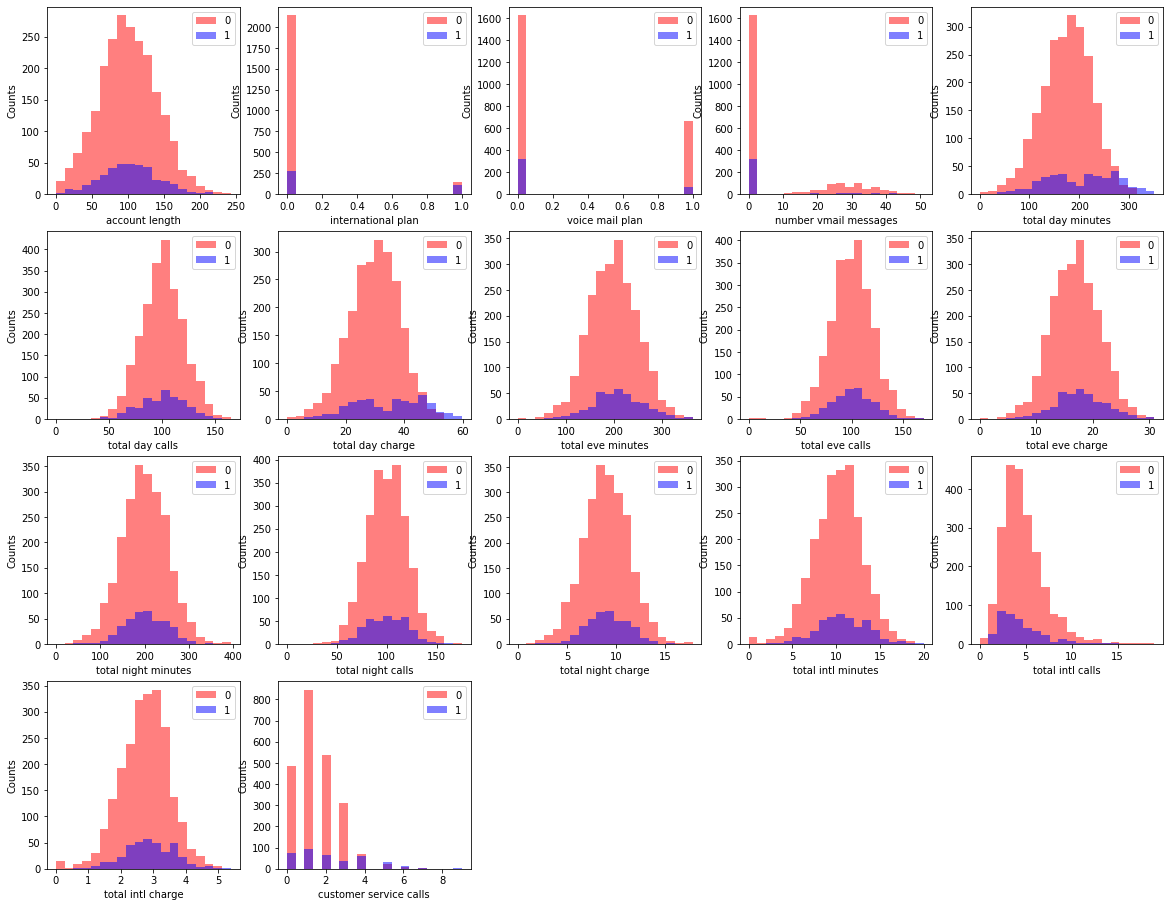

In [11]:
# Define size of the figure
plt.figure(figsize=(20, 20))

# For each column ...
for i_col in range(len(X.columns)):
    
    # Create subplot for each column
    plt.subplot(5, 5, i_col+1)
    
    # Get column and label values
    x_col = df_X_train[df_X_train.columns[i_col]].values
    y_col = y_train.values

    
    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')
    
    # Labels and legend
    plt.xlabel(df_X_train.columns[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')
    
plt.show()

### Task 5 (1 point) <br/>

Fit `DecisionTreeClassifier` from you practice in class with this sample. Find the best parameters. What is `accuracy` of the classification on the test sample?  

In [0]:
class Node(object):
    
    def __init__(self):
        """
        Class for a decision tree node.
        """
        
        self.right = None
        self.left = None
        
        self.threshold = None
        self.column = None
        
        self.depth = None
        self.probas = None
        
        self.is_terminal = False

        self.best_information_gain = 0
        self.split_efficiency = None

In [0]:
class DecisionTreeClassifier(object):
    
    def __init__(self, max_depth=3, min_samples_leaf=1, min_samples_split=2, impurity='gini'):
        """
        Class for a Decision Tree Classifier.
        
        Parameters
        ----------
        max_depth : int
            Max depth of a decision tree.
        min_samples_leaf : int
            Minimal number of samples (objects) in a leaf (terminal node).
        min_samples_split : int
            Minimal number of samples (objects) in a node to make a split.
        impurity : str
            Impurity function used for the decision tree building.
        """
        
        # Make hyperparameters visible inside the class
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.impurity = impurity
        
        # Object for the decision tree
        self.Tree = None
        
        # Helping objects
        self.classes = []
        
    def get_params(self, deep=True):
        """
        Returns class parameters.

        Parameters
        ----------
        deep : boolean
            If True, will return the parameters for this estimator and contained subobjects that are estimators.

        Returns
        -------
        params : dict
            Parameters of the class.
        """

        params = {'max_depth': self.max_depth,
                  'min_samples_leaf': self.min_samples_leaf,
                  'min_samples_split': self.min_samples_split,
                  'impurity': self.impurity}

        return params
    
    
    def set_params(self, **params):
        """
        Set class parameters.

        Parameters
        ----------
        params : dict
            Dictionary of the class parameters.
        """

        for key, value in params.items():
            setattr(self, key, value)

        return self

        
    
    def node_probabilities(self, y):
        """
        Estimate probabilities of classes in data.
        
        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2], 
                                     [0.0, 1.0], 
                                     ...]
        """
        
        # To store probas
        probas = []
        
        # For each class in data ...
        for one_class in self.classes:
            
            # Estimate probability of the class
            class_proba = 1. * (y == one_class).sum() / len(y)
            # class_proba = 0.8 (example)
            
            # Store the probability
            probas.append(class_proba)
        
        return probas
    
    
    def gini_calculation(self, probas):
        """
        Calculate gini value.
        
        Parameters
        ----------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                probas = [0.1, 0.9]
            
        Returns
        -------
        gini : float
            Gini value.
        """
        
        gini = 1
        for p in probas:
            gini -= p**2
        
        return gini
    
    
    def impurity_calculation(self, y):
        """
        Calculate data impurity.
        
        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        impurity : float
            Impuroty of the data.
        """
                
        # Estimate probabilities for each class
        probas = self.node_probabilities(y)
        # probas = [0.90, 0.10] (example)
        
        # Calculate impurity of the data
        if self.impurity == 'gini':
            impurity = self.gini_calculation(probas)
            # impurity = 0.6 (example)
        
        return impurity
        
    
    def best_split(self, X, y):
        """
        Make the best split of data in a decision tree node.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the left child that are described by their input features.
        y_left : numpy.array, shape = (n_objects)
            1D array with the object labels in the left child. 
            For the classification labels are integers in {0, 1, 2, ...}.
        X_right : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the right child that are described by their input features.
        y_right : numpy.array, shape = (n_objects)
            1D array with labels of the objects in the right child. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_information_gain = -999
        
        # Data impurity before the split
        impurity = self.impurity_calculation(y)
        # impurity = 0.8 (example)
        
        # For each column in X ...
        for split_column in range(X.shape[1]):
            
            # Select values of the column
            x_col = X[:, split_column]
            # x_col = [2.6, 1.3, 0.5, ...] (example)
            
            # For each value in the column ...
            for i_x in range(0, len(x_col)):
                
                # Take the value as a threshold for a split
                threshold = x_col[i_x]
                # threshold = 1.3 (example)
                
                # Make the split into right and left childs
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]
                # y_left = [0, 1, 1, 0, 1] (example)
                
                if len(y_right) == 0 or len(y_left) == 0:
                    continue
                
                # Calculate impurity for each child
                impurity_left = self.impurity_calculation(y_left)
                impurity_right = self.impurity_calculation(y_right)
                # impurity_right = 0.6 (example)
                
                # Calculate information gain of the split
                information_gain = impurity
                information_gain -= impurity_left * len(y_left) / len(y)
                information_gain -= impurity_right * len(y_right) / len(y)
                # information_gain = 0.2 (example)
                
                # Is this information_gain the best?
                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain
                    
        # If no split available
        if best_information_gain == -999:
            return None, None, None, None, None, None, None
        
        # Take the best split parameters and make this split
        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right, best_information_gain
                    
                
    
    def decision_tree(self, node, X, y):
        """
        Functions builds a decision tree.
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Check termination conditions
        if node.depth >= self.max_depth:    # max_depth check
            node.is_terminal = True
            return
        if len(X) < self.min_samples_split:   # min_samples_split check
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return
        
        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right, best_information_gain = self.best_split(X, y) # Make a split
        # split_column = 2 (exmaple) column index of the split
        # threshold = 2.74 (example) split_column > threshold
        
        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return
        
        
        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold
        
        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.node_probabilities(y_left)
        
        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.node_probabilities(y_right)

        node.best_information_gain = best_information_gain
        
        # Make splits for the left and right nodes
        self.decision_tree(node.right, X_right, y_right)
        self.decision_tree(node.left, X_left, y_left)


    def fit(self, X, y):
        """
        Fit the Decision Tree Classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Get unique class labels
        self.classes = np.unique(y)
        # self.classes = [0, 1] (example)
        
        # Create a root node of a decision tree
        self.Tree = Node()                             # Create an empty node
        self.Tree.depth = 1                            # the node depth
        self.Tree.probas = self.node_probabilities(y)  # init class probabilities
        
        # Build the decision tree
        self.decision_tree(self.Tree, X, y)
        
    
    def one_prediction(self, node, x):
        """
        Functions builds a decision tree.
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : numpy.array, shape = (n_features,)
            Array of feature values of one object.
        """
        
        # Termination condition
        if node.is_terminal == True:     # If it is a leaf (terminal node, no childs)
            return node.probas                           # Return probas of the terminal node
            # node.probas = [0.9, 0.1] (example)
        
        # Run to the current node's childs
        # Check split condition. If yes, go to the right child
        if x[node.column] > node.threshold:
            # Right child
            probas = self.one_prediction(node.right, x)
            # probas = [0.9, 0.1] (example)
        else: 
            # Left child
            probas = self.one_prediction(node.left, x)
            # probas = [0.9, 0.1] (example)
            
        return probas
    
    
    def predict_proba(self, X):
        """
        Predict class probabilities for unknown objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted_proba : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2], 
                                     [0.0, 1.0], 
                                     ...]
        """
        
        # Create an empty list for predicted probabilities
        y_predicted_proba = []
        
        # For each object in X make a prediction
        for one_x in X:
            
            # Make the prediction for one object 
            one_proba = self.one_prediction(self.Tree, one_x)
            # one_proba = [0.9, 0.1] (example)
            
            # Store the predictions
            y_predicted_proba.append(one_proba)
        
        return np.array(y_predicted_proba)
    
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Predict probabilities
        y_predicted_proba = self.predict_proba(X)
        # y_predicted_proba = [[0.90, 0.10], 
        #                      [0.23, 0.77], 
        #                       ...]  (example)
        
        # Find class labels with the highest probability
        y_predicted = y_predicted_proba.argmax(axis=1)
        # y_predicted = [0, 1] (example)
        
        return y_predicted


In [0]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, impurity='gini')
clf.fit(df_X_train.values, y_train.values)
y_test_predict = clf.predict(df_X_test.values)

In [99]:
# Import accuracy_score function
from sklearn.metrics import accuracy_score

# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)

print("Test accuracy of DT classifier: ", accuracy_test)

Test accuracy of DT classifier:  0.9460269865067467


### Task 6 (3 points) <br/>

Implement feature importance estimation in `DecisionTreeClassifier`. Importance of a feature $f$ is defined as follows:

* Let $T(f)$ be the set of all nodes, relying on feature $f$ when making split.
* Efficiency of split at node $t$: $\Delta I(t)=I(t)-\sum_{c\in childen(t)}\frac{n_{c}}{n_{t}}I(c)$,  where $n_t$, $n_c$ is number of samples in nodes t, c
* Feature importance of $f$: $\sum_{t\in T(f)}n_{t}\Delta I(t)$, where $n_t$ is number of samples in node t

Calculate importance of input features in your dataset. What features are the most important (informative) for the classification?

To do this you have to update your decision_tree learning procedure:
* Return best_information_gain from best_split
* Save best_information_gain in node
* Traverse tree recursively and caclulate feature importance for every feature.

In [0]:
def calculate_features_importance(node: Node, X):
    if node.is_terminal:
        node.split_efficiency = node.best_information_gain
        return
    
    curr_feature = X[:, node.column]
    left_node_elems = []
    for elem in curr_feature:
        if elem < node.threshold:
            left_node_elems.append(elem)
    
    len_left_node = len(left_node_elems)
    len_right_node = len(curr_feature) - len_left_node

    left_efficiency =  node.left.best_information_gain * (1.0 * len_left_node / len(curr_feature))
    right_efficiency = node.right.best_information_gain * (1.0 * len_right_node / len(curr_feature))
    node.split_efficiency = node.best_information_gain - left_efficiency - right_efficiency

    calculate_features_importance(node.left, X)
    calculate_features_importance(node.right, X)
    

def sum_efficiency_feature(node: Node, feature, X):
    if node.is_terminal:
        return 0
    ans = 0

    curr_feature = X.iloc[:, node.column]
    left_node_elems = []
    for elem in curr_feature:
        if elem < node.threshold:
            left_node_elems.append(elem)
    
    len_left_node = len(left_node_elems)
    len_right_node = len(curr_feature) - len_left_node
    
    if node.left.column == feature:
        ans += len_left_node * node.left.split_efficiency

    if node.right.column == feature:
        ans += len_right_node * node.right.split_efficiency

    return ans + sum_efficiency_feature(node.left, feature, X) + sum_efficiency_feature(node.right, feature, X)

def get_feature_importance(X, clf):
    calculate_features_importance(clf.Tree, X.values)
    efficiency = []
    for i in range(len(X.columns)):
      efficiency.append(sum_efficiency_feature(clf.Tree, i, X))

    indexes = np.argsort(efficiency) 
    indexes = np.flip(efficiency)
    print(indexes)
    ans = X.columns[indexes]
    return ans

In [146]:
features = get_feature_importance(df_X_train, clf)
features_order = features[:5]
print(features_order)

# Your code here
# Output: array 'features_order' from highest to lowest importance (first 5)

[-7.84084146e+01  0.00000000e+00 -3.20626541e+02  6.77535332e+02
  0.00000000e+00 -8.53942820e+01 -6.65139021e+02  0.00000000e+00
  8.94122671e+02 -1.69273080e+02  0.00000000e+00  7.80392465e+01
  2.01146187e+03 -2.86828279e+00  4.14717622e+02 -4.86308426e+02
  3.88847410e+03]


IndexError: ignored

In [134]:
assert(len(features_order)==5)
assert(np.array_equal(features_order, np.array(['total day charge', 'customer service calls', 'international plan', 'total intl calls', 'total eve charge'])))

AssertionError: ignored

### Task 7 (2 points) <br/>

Implement Reduced Error Pruning in you `DecisionTreeClassifier`. 

Fit the classifier similar to **Task 6** setting up `max_depth=20`. 

Prune this decision tree using test data. 

Create a plot "Accuracy (y-axis) vs Numbers of vertices (x-axis)" for test data.

In [0]:
# Your code here